In [12]:
import os
for c in os.listdir("data/flower_photos"):
    print(c, len(os.listdir(f"data/flower_photos/{c}")))

daisy 633
dandelion 898
roses 641
sunflowers 699
tulips 799


In [13]:
import time
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = "data/flower_photos"
image_size = 128
batch_size = 32

default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Default device:", default_device)

Default device: cuda


In [14]:
from torch.utils.data import Subset

def get_dataloaders():
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # dataset de baza, fara transform (doar pentru split de indecsi)
    base_dataset = datasets.ImageFolder(root=data_dir)
    class_names = base_dataset.classes
    num_classes = len(class_names)

    print("Classes:", class_names)
    print("Number of images:", len(base_dataset))

    train_ratio = 0.8
    train_size = int(train_ratio * len(base_dataset))
    val_size = len(base_dataset) - train_size

    train_subset_base, val_subset_base = random_split(
        base_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_indices = train_subset_base.indices
    val_indices = val_subset_base.indices

    full_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    full_val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    print("Number of train batches:", len(train_loader))
    print("Number of val batches:", len(val_loader))

    return train_loader, val_loader, class_names, num_classes


# sanity check
train_loader, val_loader, class_names, num_classes = get_dataloaders()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670
Train size: 2936, Val size: 734
Number of train batches: 92
Number of val batches: 23


In [15]:
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU(0.1)
    raise ValueError(f"Unknown activation {name}")


class FlexibleCNN(nn.Module):
    """
    Model flexibil:
    - 0–4 convolutional layers
    - opțional BatchNorm
    - opțional MaxPooling
    - 1–2 fully connected (hidden) layers
    """

    def __init__(
        self,
        num_classes: int,
        num_conv_layers: int = 3,
        num_hidden_layers: int = 1,
        hidden_dim: int = 256,
        use_batchnorm: bool = True,
        use_pooling: bool = True,
        activation: str = "relu",
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers
        self.num_hidden_layers = num_hidden_layers
        self.use_batchnorm = use_batchnorm
        self.use_pooling = use_pooling
        self.activation = get_activation(activation)

        layers = []
        in_channels = 3
        out_channels = 32

        if num_conv_layers > 0:
            for i in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_channels))
                layers.append(self.activation)
                if use_pooling:
                    layers.append(nn.MaxPool2d(2))

                in_channels = out_channels
                out_channels *= 2

            layers.append(nn.AdaptiveAvgPool2d((4, 4)))
            self.features = nn.Sequential(*layers)

            last_channels = in_channels
            fc_in_dim = last_channels * 4 * 4
        else:
            self.features = nn.Identity()
            fc_in_dim = 3 * image_size * image_size

        self.flatten = nn.Flatten()

        fc_layers = []
        if num_hidden_layers == 1:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, num_classes))
        elif num_hidden_layers == 2:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim // 2))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(0.5))
            fc_layers.append(nn.Linear(hidden_dim // 2, num_classes))
        else:
            raise ValueError("num_hidden_layers must be 1 or 2")

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
# test
test_model = FlexibleCNN(num_classes=num_classes, num_conv_layers=2, num_hidden_layers=1)
print(test_model)

FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, l1_lambda: float = 0.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    start_time = time.time()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if l1_lambda > 0.0:
            l1_norm = 0.0
            for p in model.parameters():
                l1_norm += p.abs().sum()
            loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_acc, epoch_time


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

In [17]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_confusion(all_labels, all_preds, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def print_model_parameters(model):
    print("\n Model parameters (weights & biases)")
    for name, param in model.named_parameters():
        print(f"{name}: shape={tuple(param.shape)}")

In [18]:
@dataclass
class ExperimentConfig:
    name: str
    num_conv_layers: int
    num_hidden_layers: int
    hidden_dim: int
    use_batchnorm: bool
    use_pooling: bool
    activation: str
    learning_rate: float
    l2_lambda: float
    l1_lambda: float
    num_epochs: int
    patience: int = 5


def get_experiments() -> List[ExperimentConfig]:
    return [
        ExperimentConfig(
            name="mlp_0conv_2hidden_relu_lr1e-3",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="cnn_2conv_1hidden_nobn_pool_relu_lr1e-3",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="cnn_3conv_1hidden_bn_pool_relu_lr3e-4_l2_5e-4",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),
        ExperimentConfig(
            name="cnn_4conv_2hidden_bn_nopool_tanh_lr1e-3_l1_l2",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=1e-6,
            num_epochs=15,
        ),
    ]


experiments = get_experiments()
experiments

[ExperimentConfig(name='mlp_0conv_2hidden_relu_lr1e-3', num_conv_layers=0, num_hidden_layers=2, hidden_dim=512, use_batchnorm=False, use_pooling=False, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5),
 ExperimentConfig(name='cnn_2conv_1hidden_nobn_pool_relu_lr1e-3', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5),
 ExperimentConfig(name='cnn_3conv_1hidden_bn_pool_relu_lr3e-4_l2_5e-4', num_conv_layers=3, num_hidden_layers=1, hidden_dim=256, use_batchnorm=True, use_pooling=True, activation='relu', learning_rate=0.0003, l2_lambda=0.0005, l1_lambda=0.0, num_epochs=15, patience=5),
 ExperimentConfig(name='cnn_4conv_2hidden_bn_nopool_tanh_lr1e-3_l1_l2', num_conv_layers=4, num_hidden_layers=2, hidden_dim=512, use_batchnorm=True, use_pooling=False, activation='tanh', learning_rate=0.001, l2_lambda=

In [19]:
def run_experiment(
    cfg: ExperimentConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    class_names: List[str],
    num_classes: int,
    device: torch.device,
) -> Dict[str, Any]:
    print("\n" + "=" * 80)
    print(f"Starting experiment: {cfg.name} on device {device}")
    print("=" * 80)

    model = FlexibleCNN(
        num_classes=num_classes,
        num_conv_layers=cfg.num_conv_layers,
        num_hidden_layers=cfg.num_hidden_layers,
        hidden_dim=cfg.hidden_dim,
        use_batchnorm=cfg.use_batchnorm,
        use_pooling=cfg.use_pooling,
        activation=cfg.activation,
    ).to(device)

    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.l2_lambda,
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epoch_time": [],
    }

    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    total_start = time.time()

    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_time = train_one_epoch(
            model, train_loader, criterion, optimizer, device, l1_lambda=cfg.l1_lambda
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(train_time)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
        print(f"Epoch train time: {train_time:.1f} s")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state_dict = model.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
            print(f"new best model (val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f})")
        else:
            no_improve_epochs += 1
            print(f"no improvement for {no_improve_epochs} epoch(s)")

        if no_improve_epochs >= cfg.patience:
            print(f" early stopping triggered at epoch {epoch}")
            break

    total_time = time.time() - total_start
    print(f"\nTRAINING FINISHED FOR {cfg.name}")
    print(f"Best epoch: {best_epoch} / {cfg.num_epochs}")
    print(f"Best val_loss: {best_val_loss:.4f} | Best val_acc: {best_val_acc:.4f}")
    print(f"Total training time: {total_time:.1f} s")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Final prediction + macro-F1
    all_labels, all_preds = get_predictions(model, val_loader, device)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Macro-F1 on validation: {macro_f1:.4f}")

    print_model_parameters(model)

    plot_history(history, title_prefix=cfg.name)
    plot_confusion(all_labels, all_preds, class_names, title=f"{cfg.name} - Confusion Matrix")

    result = {
        "config": cfg,
        "history": history,
        "macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "total_time": total_time,
    }
    return result


def compare_cpu_gpu(cfg: ExperimentConfig, train_loader, val_loader, class_names, num_classes):
    cpu_device = torch.device("cpu")
    gpu_device = torch.device("cuda") if torch.cuda.is_available() else None

    print("\n===== CPU vs GPU comparison for config:", cfg.name, "=====")

    print("\n### Running on CPU ###")
    res_cpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, cpu_device)

    if gpu_device is not None:
        print("\n### Running on GPU ###")
        res_gpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, gpu_device)

        print("\n=== CPU vs GPU summary ===")
        print(f"CPU total time: {res_cpu['total_time']:.1f} s")
        print(f"GPU total time: {res_gpu['total_time']:.1f} s")
        speedup = res_cpu["total_time"] / res_gpu["total_time"] if res_gpu["total_time"] > 0 else None
        if speedup is not None:
            print(f"Approx. speedup: {speedup:.2f}x")
    else:
        print("No GPU available for comparison.")



Starting experiment: cnn_2conv_1hidden_nobn_pool_relu_lr1e-3 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 1.3082 | Train acc: 0.4384
Val loss: 1.0755 | Val acc: 0.5504
Epoch train time: 11.2 s
new best model (val_loss=1.0755, val_acc=0.5504)

E

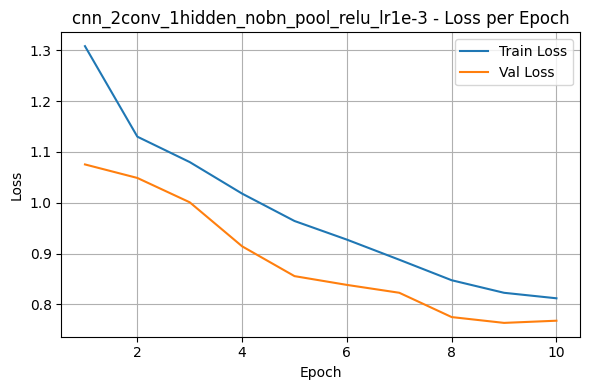

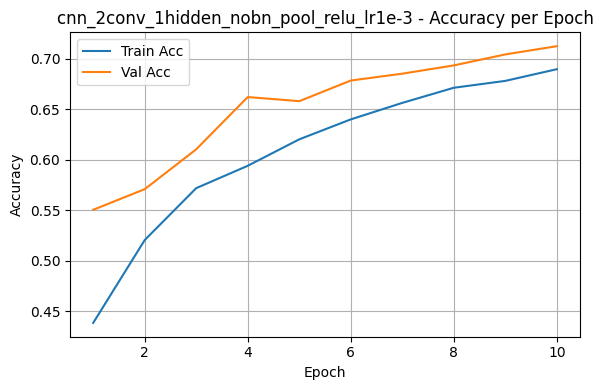

<Figure size 600x600 with 0 Axes>

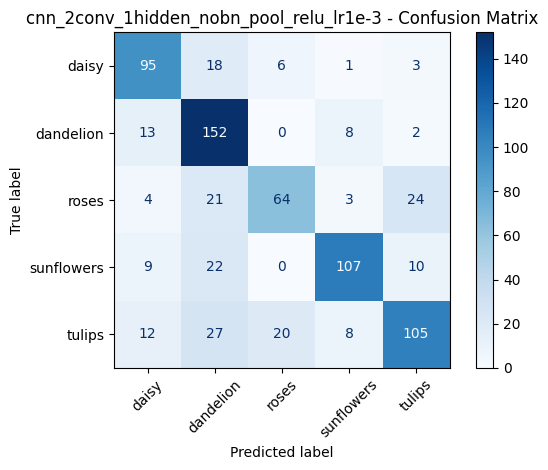

{'config': ExperimentConfig(name='cnn_2conv_1hidden_nobn_pool_relu_lr1e-3', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5),
 'history': {'train_loss': [1.308189676957819,
   1.1301424936962388,
   1.080140885117918,
   1.0180987395772492,
   0.9642461798171581,
   0.927593448506389,
   0.8880665365616697,
   0.8477003379478767,
   0.823001817721437,
   0.8121885974010914],
  'val_loss': [1.0755222233504624,
   1.0489309795545947,
   1.0010104874499162,
   0.9144218328538318,
   0.8557844447829743,
   0.838532539089629,
   0.8230545241436451,
   0.7752292822102435,
   0.7638010817912358,
   0.7680843167149078],
  'train_acc': [0.4383514986376022,
   0.5204359673024523,
   0.571866485013624,
   0.5940054495912807,
   0.6202316076294278,
   0.6399863760217984,
   0.6563351498637602,
   0.6713215258855586,
   0.678133514986376,
   0.68971389645

In [10]:
cfg = experiments[1]

result = run_experiment(
    cfg,
    train_loader,
    val_loader,
    class_names,
    num_classes,
    device=default_device,
)
result


Starting experiment: cnn_3conv_1hidden_bn_pool_relu_lr3e-4_l2_5e-4 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatt

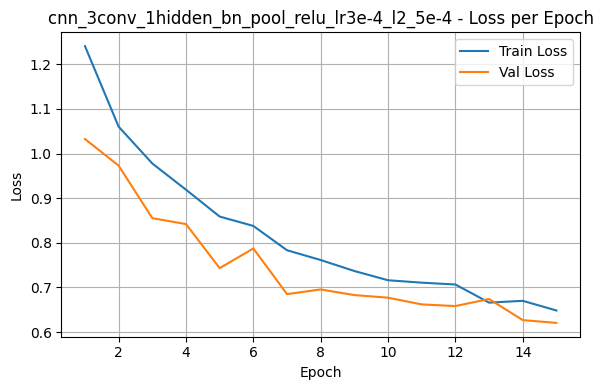

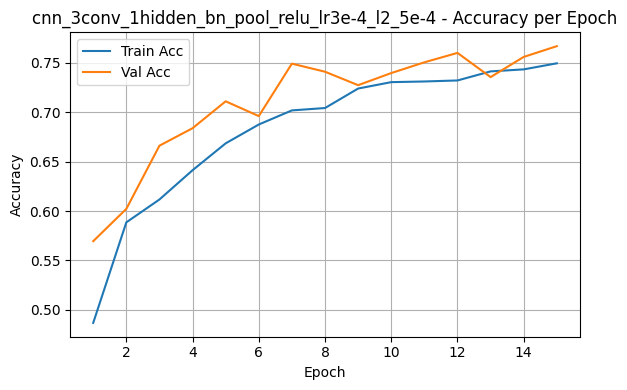

<Figure size 600x600 with 0 Axes>

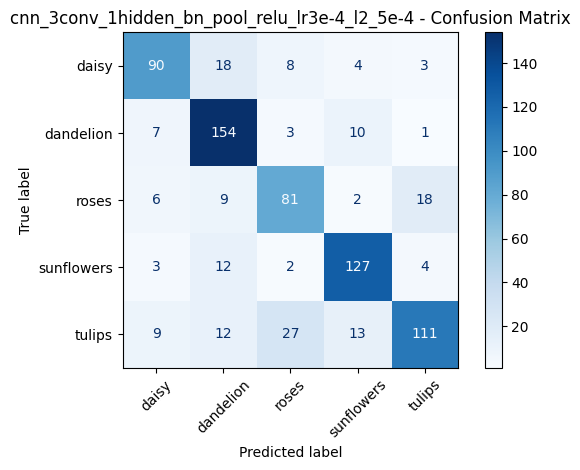

{'config': ExperimentConfig(name='cnn_3conv_1hidden_bn_pool_relu_lr3e-4_l2_5e-4', num_conv_layers=3, num_hidden_layers=1, hidden_dim=256, use_batchnorm=True, use_pooling=True, activation='relu', learning_rate=0.0003, l2_lambda=0.0005, l1_lambda=0.0, num_epochs=15, patience=5),
 'history': {'train_loss': [1.240757474944767,
   1.060248821405364,
   0.977784139258985,
   0.9190197184235264,
   0.858828078011401,
   0.8378071965248773,
   0.7833338108634429,
   0.7614006849985356,
   0.7367883160588526,
   0.716071247242452,
   0.7106760014305322,
   0.7065623340879539,
   0.6659585632160508,
   0.6699696212438536,
   0.6483066864007175],
  'val_loss': [1.0326270371756696,
   0.9729020874896557,
   0.8552381342698183,
   0.8419870721221945,
   0.7431947241362175,
   0.7873520376896663,
   0.6850378753703686,
   0.6954602842759696,
   0.682804054232969,
   0.6770077243812728,
   0.6619345233940623,
   0.6582309559840273,
   0.6740974720557315,
   0.6267371452147045,
   0.620527552648851],


In [12]:
cfg = experiments[2]

result = run_experiment(
    cfg,
    train_loader,
    val_loader,
    class_names,
    num_classes,
    device=default_device,
)
result


Starting experiment: cnn_4conv_2hidden_bn_nopool_tanh_lr1e-3_l1_l2 on device cuda
FlexibleCNN(
  (activation): Tanh()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
    (12): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
   

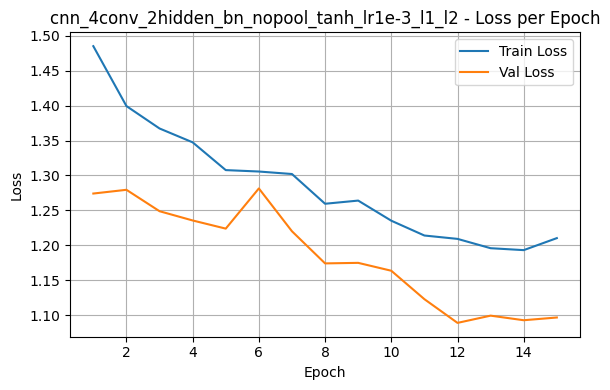

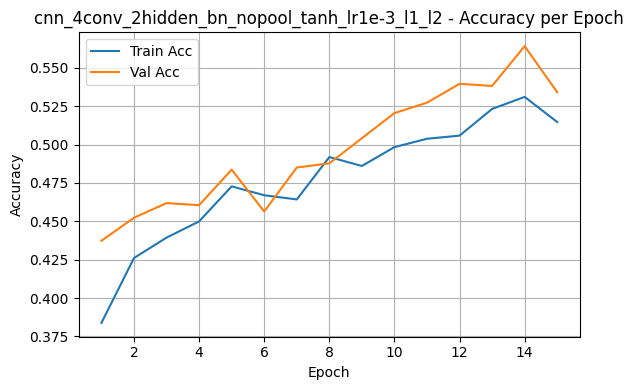

<Figure size 600x600 with 0 Axes>

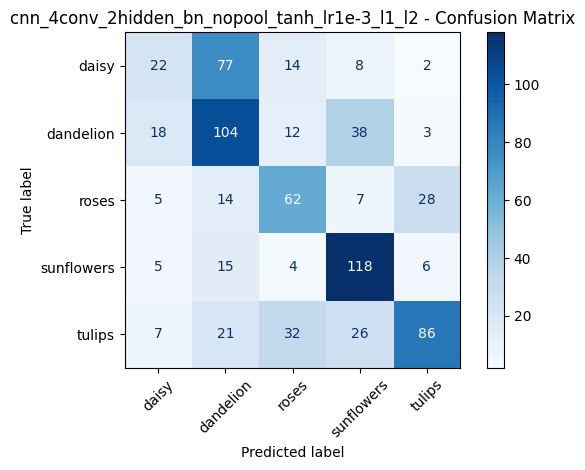

{'config': ExperimentConfig(name='cnn_4conv_2hidden_bn_nopool_tanh_lr1e-3_l1_l2', num_conv_layers=4, num_hidden_layers=2, hidden_dim=512, use_batchnorm=True, use_pooling=False, activation='tanh', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=1e-06, num_epochs=15, patience=5),
 'history': {'train_loss': [1.4849620771667937,
   1.3992780830294949,
   1.3672056971193984,
   1.3473800914488956,
   1.307654043959012,
   1.305629548000055,
   1.3020547267851452,
   1.2595113629541215,
   1.2640468729939058,
   1.2352667221906075,
   1.214072565616639,
   1.2092592810415117,
   1.19592109525561,
   1.1931731720386474,
   1.2103404050302116],
  'val_loss': [1.274131725204738,
   1.279472663227154,
   1.248845148476333,
   1.2356103216919652,
   1.2239436011873084,
   1.2814285479059662,
   1.2201467248984188,
   1.1741934027269036,
   1.174957869488147,
   1.1636719226187515,
   1.1230043523642932,
   1.0890832304629707,
   1.099439905514834,
   1.0928828316748305,
   1.0968002659098655],
 

In [13]:
cfg = experiments[3]

result = run_experiment(
    cfg,
    train_loader,
    val_loader,
    class_names,
    num_classes,
    device=default_device,
)
result


===== CPU vs GPU comparison for config: mlp_0conv_2hidden_relu_lr1e-3 =====

### Running on CPU ###

Starting experiment: mlp_0conv_2hidden_relu_lr1e-3 on device cpu
FlexibleCNN(
  (activation): ReLU()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 5.6114 | Train acc: 0.2902
Val loss: 1.6013 | Val acc: 0.3896
Epoch train time: 32.8 s
new best model (val_loss=1.6013, val_acc=0.3896)

Epoch 2/10
----------------------------------------
Train loss: 1.7624 | Train acc: 0.3089
Val loss: 1.4396 | Val acc: 0.3733
Epoch train time: 32.5 s
new best model (val_loss=1.4396, val_acc=0.

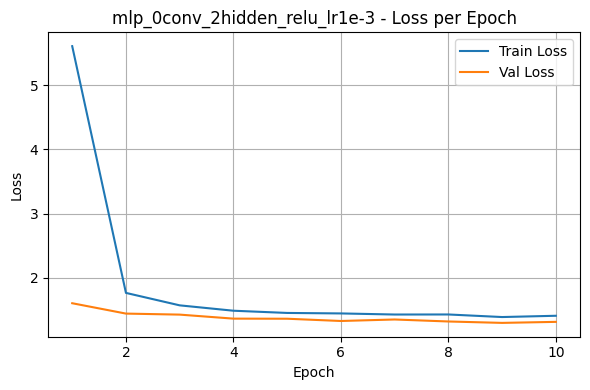

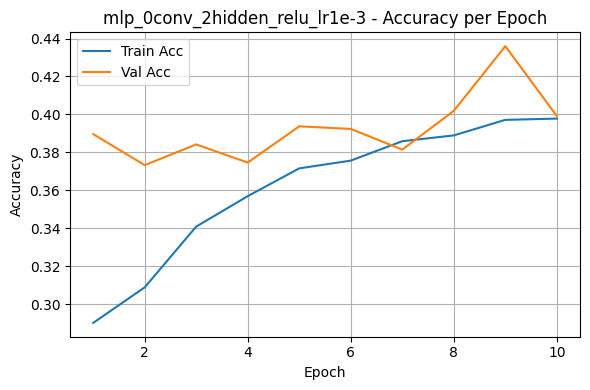

<Figure size 600x600 with 0 Axes>

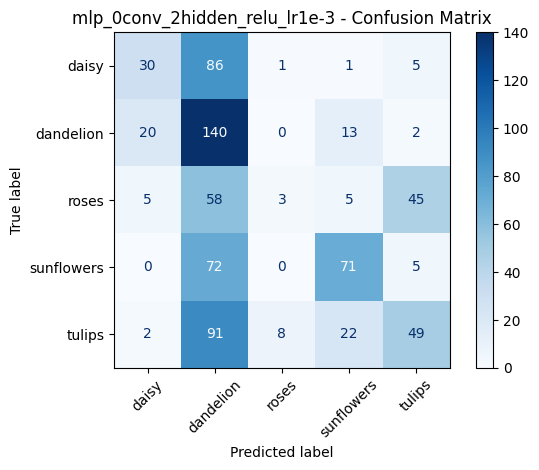


### Running on GPU ###

Starting experiment: mlp_0conv_2hidden_relu_lr1e-3 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=5, bias=True)
  )
)

Epoch 1/10
----------------------------------------
Train loss: 6.0415 | Train acc: 0.2963
Val loss: 1.5578 | Val acc: 0.3910
Epoch train time: 9.7 s
new best model (val_loss=1.5578, val_acc=0.3910)

Epoch 2/10
----------------------------------------
Train loss: 1.8311 | Train acc: 0.3191
Val loss: 1.4372 | Val acc: 0.3951
Epoch train time: 9.3 s
new best model (val_loss=1.4372, val_acc=0.3951)

Epoch 3/10
----------------------------------------
Train loss: 1.5438 

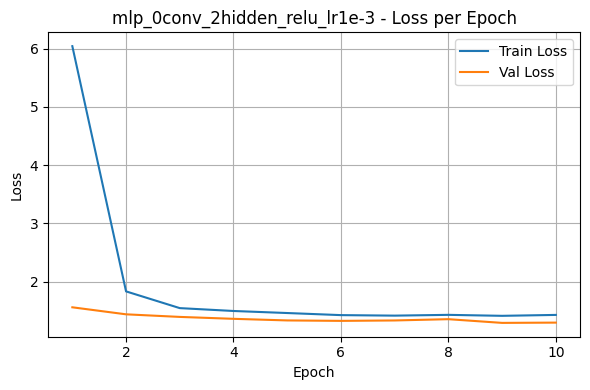

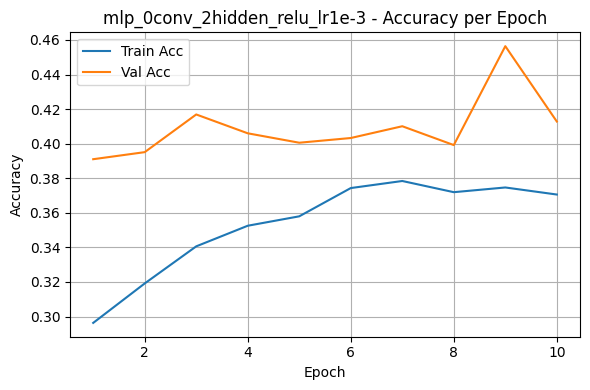

<Figure size 600x600 with 0 Axes>

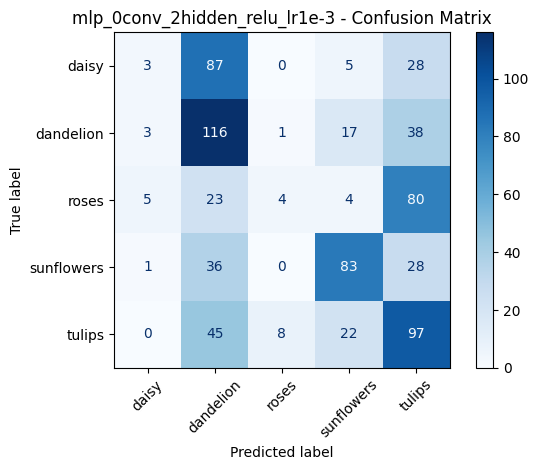


=== CPU vs GPU summary ===
CPU total time: 328.0 s
GPU total time: 124.8 s
Approx. speedup: 2.63x


In [20]:
compare_cpu_gpu(experiments[0], train_loader, val_loader, class_names, num_classes)